## Business Goal
We aim to segement the Customers based on RFM so that the company can target its customers efficiently.


In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from scipy.cluster.hierarchy import cophenet
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import PowerTransformer
from warnings import filterwarnings
filterwarnings('ignore')


In [2]:
df = pd.read_csv('OnlineRetail.csv',sep=",", encoding="ISO-8859-1", header=0)

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


# Shape of the dataset:

In [4]:
print('Number of records  :',df.shape[0])
print('Number of features :',df.shape[1])

Number of records  : 541909
Number of features : 8


# DataFrame Information:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# DataFrame Description

# Numeric Features:

In [6]:
df.describe(include='number')

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# Categorical Features:

In [7]:
df.describe(include='object')

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,540455,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,31-10-2011 14:41,United Kingdom
freq,1114,2313,2369,1114,495478


# Check the negative values:

In [8]:
negative_Quantity = df[df['Quantity']<0]['Quantity']

In [9]:
print('The total number of negative values:',len(negative_Quantity))
print('The Negative values are:',negative_Quantity.head())

The total number of negative values: 10624
The Negative values are: 141    -1
154    -1
235   -12
236   -24
237   -24
Name: Quantity, dtype: int64


# Negative values in UnitPrice :

In [10]:
df[df['UnitPrice']<0]['UnitPrice']

299983   -11062.06
299984   -11062.06
Name: UnitPrice, dtype: float64

# Clean the Data:

# Remove the Negative values:

In [11]:
df = df[df['Quantity']>=0]

In [12]:
df = df[df['UnitPrice']>=0]

# Handling the null values:

In [13]:
df.isnull().mean()

InvoiceNo      0.000000
StockCode      0.000000
Description    0.001114
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.251013
Country        0.000000
dtype: float64

In [14]:
df_null = pd.DataFrame({'null_count':df.isnull().sum(),'null_percentage':df.isnull().sum()/len(df)})

In [15]:
df_null

,null_count,null_percentage
InvoiceNo,0,0.000000
StockCode,0,0.000000
Description,592,0.001114
Quantity,0,0.000000
InvoiceDate,0,0.000000
UnitPrice,0,0.000000
CustomerID,133359,0.251013
Country,0,0.000000


In [16]:
df = df.dropna()

# check once again the null values:

In [17]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

# change the data types properly:

In [18]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [19]:
df['CustomerID'] = df['CustomerID'].astype('object')

In [20]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],format='%d-%m-%Y %H:%M')

# Data Preparation

# Creating new Feature:

#### We are going to analysis the Customers based on below 3 factors:
- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [21]:
df['Amount'] = df['Quantity']*df['UnitPrice']

In [22]:
df['Amount'].head()

0    15.30
1    20.34
2    22.00
3    20.34
4    20.34
Name: Amount, dtype: float64

Monetary:

In [23]:
rfm_m = df.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


Frequency:

In [24]:
rfm_f = df.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


Combain the two DataFrame

In [25]:
rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,77183.60,1
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


Creating the New feature called Recency

Compute the maximum date to know the last transaction date

In [26]:
max_date = max(df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

Compute the difference between max date and transaction date

In [27]:
df['Diff'] = max_date - df['InvoiceDate']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


Compute last transaction date to get the recency of customers

In [28]:
rfm_p = df.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,325 days 02:49:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


Extract number of days only

In [29]:
rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


Merge tha dataframes to get the final RFM dataframe

In [30]:
rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,77183.60,1,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


There are 2 types of outliers and we will treat outliers as it can skew our dataset
- Statistical
- Domain specific

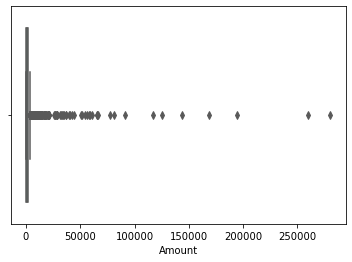

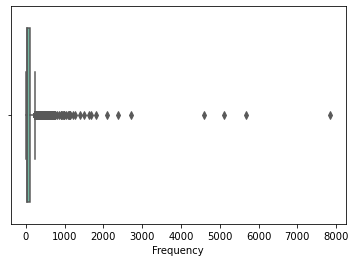

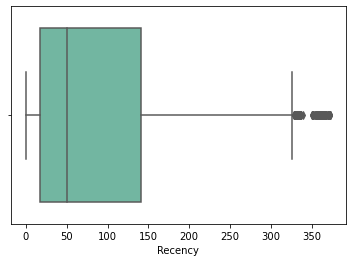

In [31]:
for features in rfm[['Amount','Frequency','Recency']].columns:
    sns.boxplot(rfm[features],palette="Set2")
    plt.show()

In [32]:
# Statistical Method:

In [33]:
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

In [34]:
rfm.shape

(4257, 4)

### Rescaling the Attributes

It is extremely important to rescale the variables so that they have a comparable scale.|
There are two common ways of rescaling:

1. Min-Max scaling 
2. Standardisation (mean-0, sigma-1) 

Here, we will use Standardisation Scaling.

In [35]:
std = StandardScaler()

Lets remove the customer_id 

In [36]:
X =rfm.drop('CustomerID',axis=1)

In [38]:
X_scaled = pd.DataFrame(std.fit_transform(X),columns=X.columns)

In [39]:
X_scaled.head()

,Amount,Frequency,Recency
0,1.645726,1.067832,-0.917872
1,0.262124,-0.460601,-0.189272
2,0.240269,-0.035474,-0.748198
3,-0.543361,-0.602310,2.156221
4,0.652411,0.085991,-0.578524


# Model Building:

In [40]:
wcss = []
for i in range(1,8):
    kmeans = KMeans(n_clusters=i,n_init=10,n_jobs=-1,random_state=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Find the optimal Cluster using Lbow method:

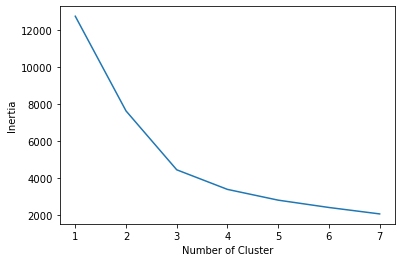

In [41]:
plt.plot(range(1,8),wcss)
plt.xlabel('Number of Cluster')
plt.ylabel('Inertia')
plt.show()

we can see the lbow plot, The curve bend at the second cluster.

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [42]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(X)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    

For n_clusters=2, the silhouette score is 0.7756852525530141
For n_clusters=3, the silhouette score is 0.7019678230589711
For n_clusters=4, the silhouette score is 0.6486685874316034
For n_clusters=5, the silhouette score is 0.6101878035102121
For n_clusters=6, the silhouette score is 0.5695534181025024
For n_clusters=7, the silhouette score is 0.5384692548221451
For n_clusters=8, the silhouette score is 0.517626738480216


we can see that cluster 2 is the optimal k_cluster.

### Building the Kmeans model with 2 cluster:

In [43]:
kmeans = KMeans(n_clusters=2,n_init=10,n_jobs=-1,random_state=10)
kmeans.fit(X)

KMeans(n_clusters=2, n_jobs=-1, random_state=10)

In [44]:
kmeans.labels_

array([0, 1, 1, ..., 1, 1, 1])

In [45]:
rfm['Lables'] = kmeans.labels_

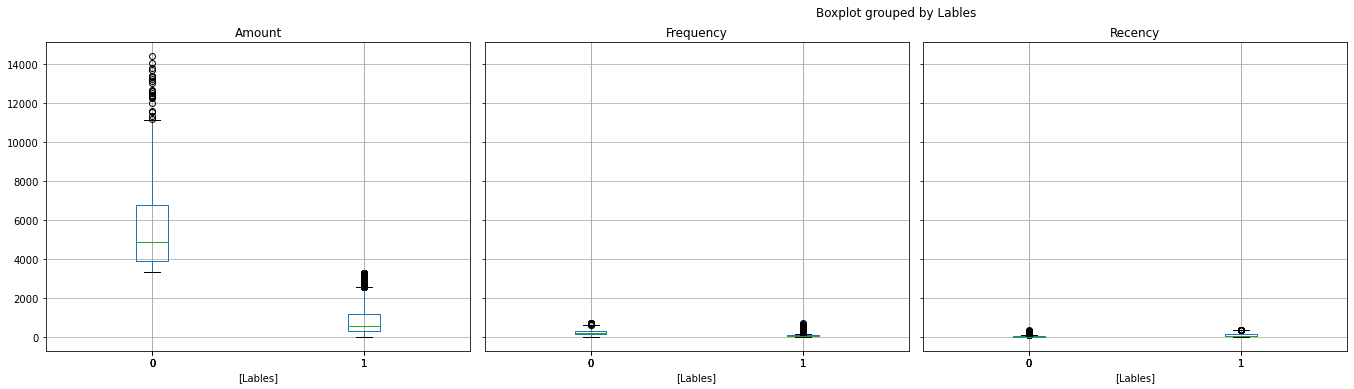

In [51]:
rfm[['Amount','Frequency','Recency','Lables']].boxplot(by = 'Lables',  layout=(2,4), figsize=(25, 10))
plt.tight_layout()

### Hierarchical Clustering

Hierarchical clustering involves creating clusters that have a predetermined ordering from top to bottom. For example, all files and folders on the hard disk are organized in a hierarchy. There are two types of hierarchical clustering, 
- Divisive 
- Agglomerative.

ERROR! Session/line number was not unique in database. History logging moved to new session 142


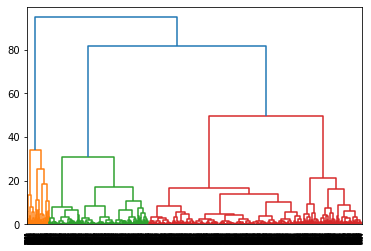

In [50]:
mergings = linkage(X_scaled, method="ward", metric='euclidean')
dendrogram(mergings)
plt.show()

# Measure the dendogram quality:

In [53]:
eucli_dist = euclidean_distances(X_scaled)
dist_array = eucli_dist[np.triu_indices(len(X_scaled), k = 1)]
coeff, cophenet_dist = cophenet(mergings, dist_array)
print(coeff)

0.6817844702270469


# DBSCAN Model:

In [54]:
dbscan_model = DBSCAN(eps=0.5,min_samples=5,n_jobs=-1)
dbscan_model.fit(X_scaled)

DBSCAN(n_jobs=-1)

In [56]:
set(dbscan_model.labels_)

{-1, 0, 1, 2, 3, 4}